In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import required libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import string
import itertools
from wordcloud import WordCloud, ImageColorGenerator
import nltk 
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
from tensorflow.keras.losses import Hinge
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegressionCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### ISOT Dataset loading

In [4]:
true = pd.read_csv('/content/drive/MyDrive/True.csv', encoding='latin', header=None)
true.head(5)

0  \
0                                              title   
1  As U.S. budget fight looms, Republicans flip t...   
2  U.S. military to accept transgender recruits o...   
3  Senior U.S. Republican senator: 'Let Mr. Muell...   
4  FBI Russia probe helped by Australian diplomat...   

                                                   1             2  \
0                                               text       subject   
1  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
2  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
3  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
4  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   

                    3  
0                date  
1  December 31, 2017   
2  December 29, 2017   
3  December 31, 2017   
4  December 30, 2017

In [5]:
false = pd.read_csv('/content/drive/MyDrive/Fake.csv', encoding='latin', header=None)
false.head(5)

0  \
0                                              title   
1   Donald Trump Sends Out Embarrassing New Yearâ...   
2   Drunk Bragging Trump Staffer Started Russian ...   
3   Sheriff David Clarke Becomes An Internet Joke...   
4   Trump Is So Obsessed He Even Has Obamaâs Na...   

                                                   1        2  \
0                                               text  subject   
1  Donald Trump just couldn t wish all Americans ...     News   
2  House Intelligence Committee Chairman Devin Nu...     News   
3  On Friday, it was revealed that former Milwauk...     News   
4  On Christmas day, Donald Trump announced that ...     News   

                   3  
0               date  
1  December 31, 2017  
2  December 31, 2017  
3  December 30, 2017  
4  December 29, 2017

### Data set Examination

In [6]:
true = true.drop([0], axis=0)
true.head(5)

0  \
1  As U.S. budget fight looms, Republicans flip t...   
2  U.S. military to accept transgender recruits o...   
3  Senior U.S. Republican senator: 'Let Mr. Muell...   
4  FBI Russia probe helped by Australian diplomat...   
5  Trump wants Postal Service to charge 'much mor...   

                                                   1             2  \
1  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
2  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
3  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
4  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
5  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                    3  
1  December 31, 2017   
2  December 29, 2017   
3  December 31, 2017   
4  December 30, 2017   
5  December 29, 2017

In [7]:
false = false.drop([0], axis=0)
false.head(5)

0  \
1   Donald Trump Sends Out Embarrassing New Yearâ...   
2   Drunk Bragging Trump Staffer Started Russian ...   
3   Sheriff David Clarke Becomes An Internet Joke...   
4   Trump Is So Obsessed He Even Has Obamaâs Na...   
5   Pope Francis Just Called Out Donald Trump Dur...   

                                                   1     2                  3  
1  Donald Trump just couldn t wish all Americans ...  News  December 31, 2017  
2  House Intelligence Committee Chairman Devin Nu...  News  December 31, 2017  
3  On Friday, it was revealed that former Milwauk...  News  December 30, 2017  
4  On Christmas day, Donald Trump announced that ...  News  December 29, 2017  
5  Pope Francis used his annual Christmas Day mes...  News  December 25, 2017

### Adding the correct title for columns

In [8]:
true.columns = ['title', 'text', 'subject','date']
true.head(5)

title  \
1  As U.S. budget fight looms, Republicans flip t...   
2  U.S. military to accept transgender recruits o...   
3  Senior U.S. Republican senator: 'Let Mr. Muell...   
4  FBI Russia probe helped by Australian diplomat...   
5  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
1  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
2  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
3  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
4  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
5  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
1  December 31, 2017   
2  December 29, 2017   
3  December 31, 2017   
4  December 30, 2017   
5  December 29, 2017

In [9]:
false.columns = ['title', 'text', 'subject','date']
false.head(5)

title  \
1   Donald Trump Sends Out Embarrassing New Yearâ...   
2   Drunk Bragging Trump Staffer Started Russian ...   
3   Sheriff David Clarke Becomes An Internet Joke...   
4   Trump Is So Obsessed He Even Has Obamaâs Na...   
5   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
1  Donald Trump just couldn t wish all Americans ...    News   
2  House Intelligence Committee Chairman Devin Nu...    News   
3  On Friday, it was revealed that former Milwauk...    News   
4  On Christmas day, Donald Trump announced that ...    News   
5  Pope Francis used his annual Christmas Day mes...    News   

                date  
1  December 31, 2017  
2  December 31, 2017  
3  December 30, 2017  
4  December 29, 2017  
5  December 25, 2017

In [10]:
print(false.shape)
print(true.shape)

(23481, 4)
(21417, 4)


### Apply integer values to the real and fake news datasets

In [11]:
true['sentiment'] = 1
false['sentiment'] = 0

In [12]:
true.head(5)

title  \
1  As U.S. budget fight looms, Republicans flip t...   
2  U.S. military to accept transgender recruits o...   
3  Senior U.S. Republican senator: 'Let Mr. Muell...   
4  FBI Russia probe helped by Australian diplomat...   
5  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
1  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
2  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
3  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
4  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
5  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  sentiment  
1  December 31, 2017           1  
2  December 29, 2017           1  
3  December 31, 2017           1  
4  December 30, 2017           1  
5  December 29, 2017           1

### Word Clouds representations of real news 

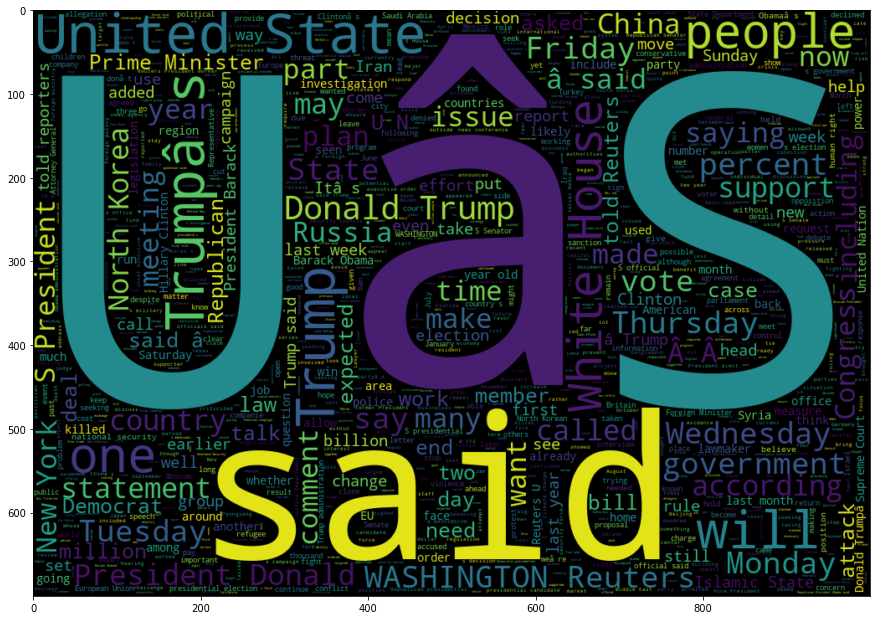

In [13]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 1000 , width = 1000 , height = 700 , stopwords = STOPWORDS).generate(" ".join(true.text))
plt.imshow(wc , interpolation = 'bilinear')

In [14]:
false.head(5)

title  \
1   Donald Trump Sends Out Embarrassing New Yearâ...   
2   Drunk Bragging Trump Staffer Started Russian ...   
3   Sheriff David Clarke Becomes An Internet Joke...   
4   Trump Is So Obsessed He Even Has Obamaâs Na...   
5   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
1  Donald Trump just couldn t wish all Americans ...    News   
2  House Intelligence Committee Chairman Devin Nu...    News   
3  On Friday, it was revealed that former Milwauk...    News   
4  On Christmas day, Donald Trump announced that ...    News   
5  Pope Francis used his annual Christmas Day mes...    News   

                date  sentiment  
1  December 31, 2017          0  
2  December 31, 2017          0  
3  December 30, 2017          0  
4  December 29, 2017          0  
5  December 25, 2017          0

### Word Clouds representations of fake news 

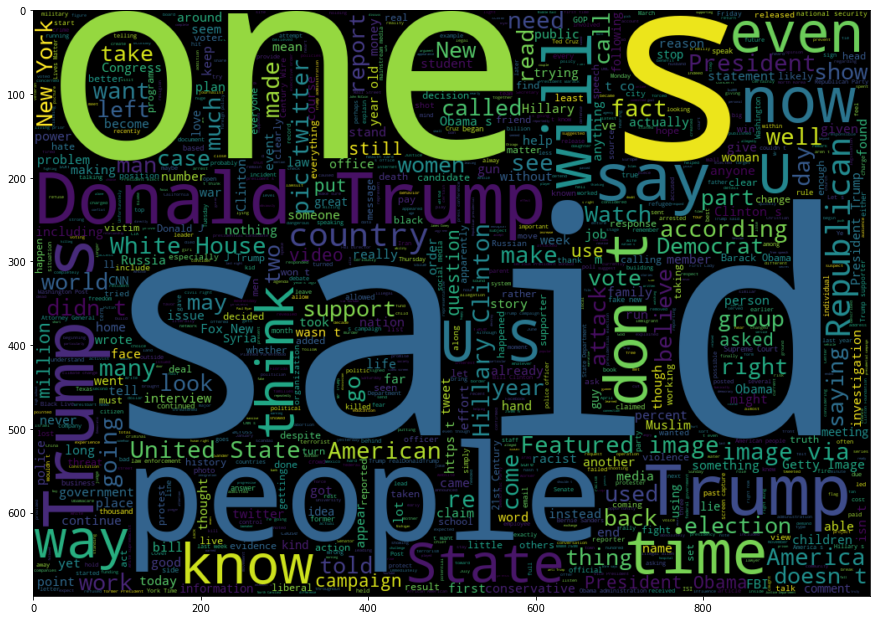

In [15]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 1000 , width = 1000 , height = 700 , stopwords = STOPWORDS).generate(" ".join(false.text))
plt.imshow(wc , interpolation = 'bilinear')

### Concatenate (real,fake)

In [16]:
true_data = true.iloc[:int(len(true)/2.1417)]
false_data = false.iloc[:int(len(false)/2.3481)]
print(len(true_data), len(false_data))

10000 10000


In [17]:
news = pd.concat([true_data,false_data]) 
len(news)

20000

In [18]:
news

title  \
1      As U.S. budget fight looms, Republicans flip t...   
2      U.S. military to accept transgender recruits o...   
3      Senior U.S. Republican senator: 'Let Mr. Muell...   
4      FBI Russia probe helped by Australian diplomat...   
5      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
9996   LOL! SHAKEDOWN ARTIST JESSE JACKSON TELLS CROW...   
9997   President and First Lady Arrive in Texas: Serv...   
9998   Heavenâs Gatekeeper? Jesse Jackson Proclaims...   
9999   First Lady Melania Trump Defies Criticsâ¦Rock...   
10000  Watch Womenâs March Activist: âMissing Bla...   

                                                    text       subject  \
1      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
2      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
3      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
4      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
5      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
9996   Here s a 1999 video of Jesse Jackson praising ...      politics   
9997   Check out what s happening in Texas! President...      politics   
9998   Jesse Jackson thinks he s Heaven s gatekeeper ...      politics   
9999   The media will lose it again because Melania T...      politics   
10000  Unbelievable! Women s March Activist went off ...      politics   

                     date  sentiment  
1      December 31, 2017           1  
2      December 29, 2017           1  
3      December 31, 2017           1  
4      December 30, 2017           1  
5      December 29, 2017           1  
...                   ...        ...  
9996          Sep 2, 2017          0  
9997          Sep 2, 2017          0  
9998          Sep 2, 2017          0  
9999          Sep 2, 2017          0  
10000         Sep 2, 2017          0  

[20000 rows x 5 columns]

In [19]:
list(news.columns.values)

['title', 'text', 'subject', 'date', 'sentiment']

In [20]:
print(news.shape)

(20000, 5)


In [21]:
news.shape

(20000, 5)

In [22]:
news.count()

title        20000
text         20000
subject      20000
date         20000
sentiment    20000
dtype: int64

In [23]:
news.dtypes

title        object
text         object
subject      object
date         object
sentiment     int64
dtype: object

In [24]:
sentiment_counts = news.sentiment.value_counts()
print(sentiment_counts)

1    10000
0    10000
Name: sentiment, dtype: int64


In [25]:
text_counts = news.text.value_counts()
print(text_counts)

(Reuters) - Highlights for U.S. President Donald Trumpâs administration on Thursday: The United States drops a massive GBU-43 bomb, the largest non-nuclear bomb it has ever used in combat, in Afghanistan against a series of caves used by Islamic State militants, the Pentagon says. Trump says Pyongyang is a problem that âwill be taken care ofâ amid speculation that North Korea is on the verge of a sixth nuclear test. Military force cannot resolve tension over North Korea, China warns, while an influential Chinese newspaper urges Pyongyang to halt its nuclear program in exchange for Beijingâs protection. The Trump administration is focusing its North Korea strategy on tougher economic sanctions, possibly including intercepting cargo ships and punishing Chinese banks doing business with Pyongyang, U.S. officials say. Trump says âthings will work out fineâ between the United States and Russia, a day after declaring U.S.-Russian relations may be at an all-time low. Trump signals

In [26]:
news.describe()

sentiment
count  20000.000000
mean       0.500000
std        0.500013
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000

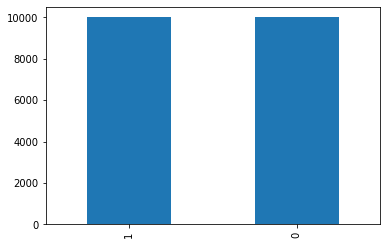

In [27]:
news['sentiment'].value_counts().plot(kind='bar')

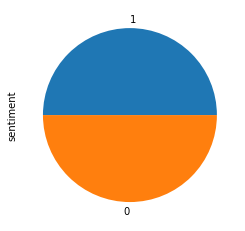

In [28]:
news['sentiment'].value_counts().plot(kind='pie')

In [29]:
data=news.drop(["date","title","subject"],axis=1)

In [30]:
data

text  sentiment
1      WASHINGTON (Reuters) - The head of a conservat...          1
2      WASHINGTON (Reuters) - Transgender people will...          1
3      WASHINGTON (Reuters) - The special counsel inv...          1
4      WASHINGTON (Reuters) - Trump campaign adviser ...          1
5      SEATTLE/WASHINGTON (Reuters) - President Donal...          1
...                                                  ...        ...
9996   Here s a 1999 video of Jesse Jackson praising ...          0
9997   Check out what s happening in Texas! President...          0
9998   Jesse Jackson thinks he s Heaven s gatekeeper ...          0
9999   The media will lose it again because Melania T...          0
10000  Unbelievable! Women s March Activist went off ...          0

[20000 rows x 2 columns]

### dataset shape analysis

In [32]:
encoded_data = data

In [33]:
print(data.shape)

(20000, 2)


In [34]:
labels_to_sentiment = {0:"negative", 1:"positive"}
def label_decoder(label):
    return labels_to_sentiment[label]
    encoded_data.sentiment = encoded_data.sentiment.apply(lambda x: label_decoder(x))
encoded_data.head(5)

text  sentiment
1  WASHINGTON (Reuters) - The head of a conservat...          1
2  WASHINGTON (Reuters) - Transgender people will...          1
3  WASHINGTON (Reuters) - The special counsel inv...          1
4  WASHINGTON (Reuters) - Trump campaign adviser ...          1
5  SEATTLE/WASHINGTON (Reuters) - President Donal...          1

Text(0.5, 1.0, '1.7 Million Twitter Tweets Sentiment Data Distribution')

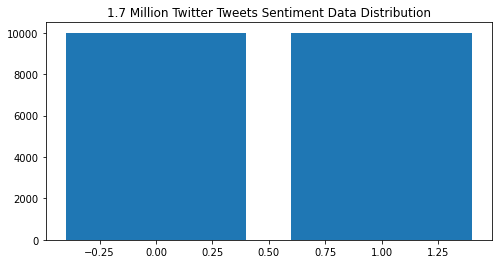

In [35]:
val_count = encoded_data.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("1.7 Million Twitter Tweets Sentiment Data Distribution")

In [36]:
reduced_data = encoded_data
reduced_data.head(10)

text  sentiment
1   WASHINGTON (Reuters) - The head of a conservat...          1
2   WASHINGTON (Reuters) - Transgender people will...          1
3   WASHINGTON (Reuters) - The special counsel inv...          1
4   WASHINGTON (Reuters) - Trump campaign adviser ...          1
5   SEATTLE/WASHINGTON (Reuters) - President Donal...          1
6   WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...          1
7   WEST PALM BEACH, Fla (Reuters) - President Don...          1
8   The following statementsÂ were posted to the v...          1
9   The following statementsÂ were posted to the v...          1
10  WASHINGTON (Reuters) - Alabama Secretary of St...          1

In [37]:
cleaned_data = reduced_data
cleaned_data.head(5)

text  sentiment
1  WASHINGTON (Reuters) - The head of a conservat...          1
2  WASHINGTON (Reuters) - Transgender people will...          1
3  WASHINGTON (Reuters) - The special counsel inv...          1
4  WASHINGTON (Reuters) - Trump campaign adviser ...          1
5  SEATTLE/WASHINGTON (Reuters) - President Donal...          1

### Text Preprocessing removing URL, HTML, Unnecessary texts, integers, emojis, punctuation etc 

In [38]:
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

In [39]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"    

def text_cleaning(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    return text

In [40]:
def number_cleaning(text):
    text = ''.join(c for c in text if not c.isdigit())
    return text

In [41]:
def remove_emoji(string):
    emoji_pattern = re.compile(
    "["
        u"\U0001F600-\U0001F64F" #emoticons
        u"\U0001F300-\U0001F5FF" #symbols & pictographs
        u"\U0001F680-\U0001F6FF" #transport & map symbols
        u"\U0001F1E0-\U0001F1FF" #FLAGS on (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

In [42]:
def remove_punctuation(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

In [43]:
def stemming_words(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [44]:
stop = set(stopwords.words("english"))

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    
    return " ".join(text)

In [45]:
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_URL(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_html(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: text_cleaning(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: number_cleaning(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_emoji(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_punctuation(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: stemming_words(x))
cleaned_data["text"] = cleaned_data["text"].apply(remove_stopwords)

In [46]:
cleaned_data.head(5)

text  sentiment
1  washington reuter head conserv republican fact...          1
2  washington reuter transgend peopl allow first ...          1
3  washington reuter special counsel investig lin...          1
4  washington reuter trump campaign advis georg p...          1
5  seattl washington reuter presid donald trump c...          1

In [47]:
cleaned_data.text

1        washington reuter head conserv republican fact...
2        washington reuter transgend peopl allow first ...
3        washington reuter special counsel investig lin...
4        washington reuter trump campaign advis georg p...
5        seattl washington reuter presid donald trump c...
                               ...                        
9996     video jess jackson prais donald trump hi contr...
9997     check happen texa presid trump first ladi arri...
9998     jess jackson think heaven gatekeep arrog rever...
9999     media lose becaus melania trump wore stiletto ...
10000    unbeliev women march activist went crazi rant ...
Name: text, Length: 20000, dtype: object

### Word Clouds representations of Concatenate (real, fake)

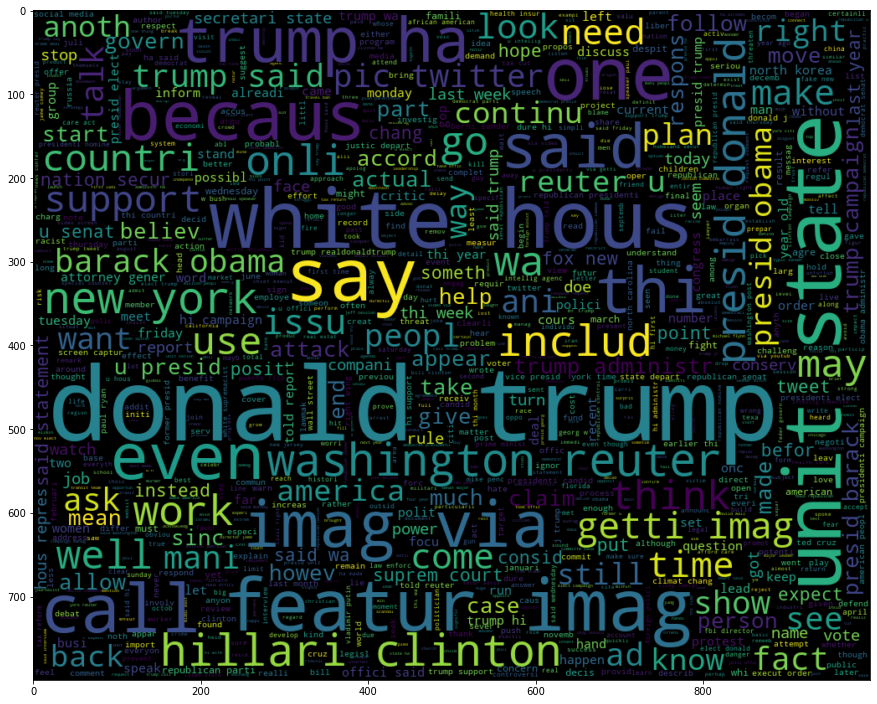

In [48]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 1000 , width = 1000 , height = 800 , stopwords = STOPWORDS).generate(" ".join(cleaned_data.text))
plt.imshow(wc , interpolation = 'bilinear')

### Split the Dataset

In [49]:
train_size = 0.8

In [50]:
train_data, test_data = train_test_split(cleaned_data, test_size=1-train_size,
                                         random_state=7)

print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 16000
Test Data size 4000


In [51]:
train_data.head(10)

text  sentiment
8119  thi sept stori correct ask first paragraph rai...          1
172   thi morn donald trump tweet health insur premi...          0
9400  washington reuter u state depart inspector gen...          1
2670  keith olbermann minc word come donald trump av...          0
8810  donald trump made appear last night tonight sh...          0
3870  elect night novemb took everyon surpris poll s...          0
3321  new york reuter former fbi director jame comey...          1
4690  onli mistak hillari clinton made say half trum...          0
3088  seen least heard meryl streep speech golden gl...          0
5993  transgend societi doe understand often activ d...          0

### Tokenisation, training datsets, sequences, padding 

In [52]:
vocabulary_size = 100000
max_word_length = 600
oov_tk = "<OOV>"
trunc_type='post'
padding_type='post'

In [53]:
tokenizer = Tokenizer(num_words = vocabulary_size, oov_token = oov_tk)
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index  
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary Size :", vocab_size)

Vocabulary Size : 48564


In [54]:
train_sequences = tokenizer.texts_to_sequences(train_data.text) 
test_sequences = tokenizer.texts_to_sequences(test_data.text)

In [55]:
x_train = pad_sequences(train_sequences, maxlen=max_word_length, padding=padding_type, truncating=trunc_type)
x_test = pad_sequences(test_sequences, maxlen=max_word_length, padding=padding_type, truncating=trunc_type)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (16000, 600)
Testing X Shape: (4000, 600)


###  Label Encoding

In [56]:
labels = train_data.sentiment.unique().tolist()

In [57]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (16000, 1)
y_test shape: (4000, 1)


In [58]:
vocabulary_size =len(word_index)
print('The size of the news dataset vocabulary is: ', vocabulary_size)

The size of the news dataset vocabulary is:  48563


In [59]:
training_sequence = x_train.shape[1]
print('The length of training sequence is: ', training_sequence)

The length of training sequence is:  600


In [60]:
print('The length of testing sequence is: ', x_test.shape[1])

The length of testing sequence is:  600


### Pretrained GloVe.6B.200 word embedding

In [61]:
embeddings_index = {}

with open('/content/drive/MyDrive/glove.6B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [62]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 48563 unique tokens.


In [63]:
embeddings_index

{'the': array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
         3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
         1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
        -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
         4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
         7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
         1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
        -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
        -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
         6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
        -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
         8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
         1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
         1.4379e-01, -1.2325e-01, -5.8178e-0

In [64]:
num_words = len(word_index) + 1
embedding_dimension = 200

embedding_matrix = np.zeros((vocab_size, embedding_dimension))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [65]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.80177999,  0.16873001,  0.17636   , ...,  0.70449001,
         0.46037999, -0.26025   ],
       ...,
       [-0.74856001, -0.19621   , -0.54395998, ...,  0.1714    ,
        -0.17726   , -0.17742001],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [66]:
word_index["good"]

174

In [67]:
embeddings_index.get("good")

array([ 5.1507e-01,  3.5596e-01,  1.5710e-01, -7.4075e-02, -2.5446e-01,
       -1.1357e-01, -4.9943e-01, -1.2626e-01,  3.8851e-01,  5.4204e-01,
        1.0479e-01,  4.4099e-01, -6.5490e-02,  5.8463e-02,  4.1150e-01,
        5.6709e-01, -1.1869e-01,  2.5107e-01,  2.5640e-01, -2.1615e-01,
        6.4170e-01,  2.7875e+00,  1.2036e-01,  4.9481e-02,  2.4843e-01,
       -6.7390e-01,  1.1957e-03,  3.5802e-01, -1.7588e-01, -3.9135e-01,
       -1.4093e-02,  2.3610e-01, -4.3184e-01, -2.7045e-02,  2.2829e-02,
       -2.8283e-01, -5.0008e-01, -1.1275e-01, -4.5002e-01,  3.3634e-01,
       -5.7722e-03,  3.3005e-01, -2.4671e-01,  1.7358e-01, -3.5508e-01,
       -3.9378e-02,  4.8834e-01,  1.4180e-01, -1.7579e-01,  3.1760e-01,
       -1.5194e-01, -1.1244e-01, -7.0078e-02,  7.4877e-01, -6.2074e-02,
       -1.7296e-01,  1.5001e-01, -5.8035e-02,  1.9471e-01, -2.9521e-01,
        5.0281e-01, -3.3074e-01, -5.4041e-01,  6.4659e-02,  4.1465e-02,
        4.9930e-01,  8.0902e-02,  4.7806e-01,  5.8307e-01,  4.08

In [68]:
(embedding_matrix[174] == embeddings_index.get("good")).all()

True

### Analysing the shapes of training and testing datasets

In [69]:
print(x_train.shape)
print(y_train.shape)

(16000, 600)
(16000, 1)


In [70]:
print(x_test.shape)
print(y_test.shape)

(4000, 600)
(4000, 1)


In [71]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on GPU...


## Employ LSTM

In [72]:
LSTM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM((128)),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax'),
  tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [73]:
LSTM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
print(LSTM_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 200)          9712800   
                                                                 
 dropout (Dropout)           (None, 600, 200)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 200)               25800     
                                                                 
 dense_1 (Dense)             (None, 5)                 1005      
                                                                 
 dense_2 (Dense)             (None, 1)                 6

### Training Model

In [74]:
number_of_epochs = 25
batch_size = 256

LSTM_history = LSTM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/25
63/63 [==============================] - 12s 88ms/step - loss: 1.0112 - accuracy: 0.4971 - val_loss: 1.0186 - val_accuracy: 0.5345
Epoch 2/25
63/63 [==============================] - 5s 74ms/step - loss: 0.9907 - accuracy: 0.5389 - val_loss: 0.9880 - val_accuracy: 0.5810
Epoch 3/25
63/63 [==============================] - 5s 74ms/step - loss: 0.9790 - accuracy: 0.5500 - val_loss: 1.0480 - val_accuracy: 0.4835
Epoch 4/25
63/63 [==============================] - 5s 75ms/step - loss: 1.0029 - accuracy: 0.5094 - val_loss: 1.0478 - val_accuracy: 0.4837
Epoch 5/25
63/63 [==============================] - 5s 74ms/step - loss: 0.9885 - accuracy: 0.5280 - val_loss: 0.9744 - val_accuracy: 0.5767
Epoch 6/25
63/63 [==============================] - 5s 76ms/step - loss: 0.7265 - accuracy: 0.7796 - val_loss: 0.7131 - val_accuracy: 0.7530
Epoch 7/25
63/63 [==============================] - 5s 76ms/step - loss: 0.6390 - accuracy: 0.7942 - val_loss: 0.6409 - val_accuracy: 0.8002
Epoch 8/25
6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'down right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


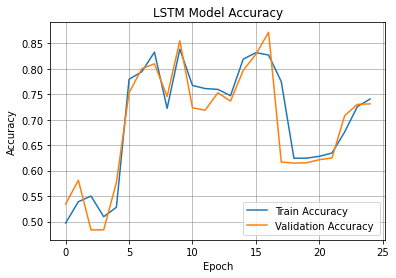

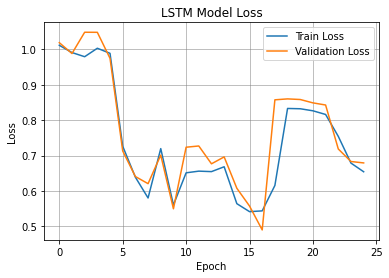

In [75]:
plt.plot(LSTM_history.history['accuracy'])
plt.plot(LSTM_history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy '], loc='down right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()


plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

### Model predication and evaluation

In [76]:
test_loss, test_acc = LSTM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

125/125 [==============================] - 2s 15ms/step - loss: 0.6793 - accuracy: 0.7312
Test Loss: 0.6792722344398499
Test Accuracy: 0.731249988079071


In [77]:
model_scores = LSTM_model.predict(x_test, verbose=1, batch_size=256)

16/16 [==============================] - 1s 24ms/step


In [78]:
model_scores

array([[ 1.0000008 ],
       [ 1.0000008 ],
       [-0.50198984],
       ...,
       [ 1.0000008 ],
       [ 1.0000008 ],
       [-0.50198984]], dtype=float32)

In [79]:
LSTM_y_pred=np.where(model_scores>0.5,1,0)

In [80]:
LSTM_y_pred

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [81]:
print(accuracy_score(y_test, LSTM_y_pred))

0.73125


In [82]:
print(classification_report(y_test, LSTM_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.50      0.66      2077
           1       0.65      0.98      0.78      1923

    accuracy                           0.73      4000
   macro avg       0.80      0.74      0.72      4000
weighted avg       0.81      0.73      0.72      4000



### confusion_matrix

In [83]:
LSTM_CM=confusion_matrix(y_test, LSTM_y_pred)
print(LSTM_CM)

[[1048 1029]
 [  46 1877]]


In [84]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[1048 1029]
 [  46 1877]]


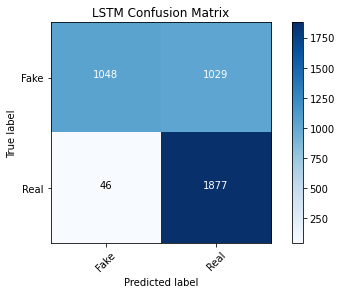

In [85]:
categories = ['Fake','Real']
LSTM_cnf_matrix = confusion_matrix(y_test, LSTM_y_pred)
plot_confusion_matrix(cm=LSTM_cnf_matrix, classes=categories, title='LSTM Confusion Matrix')
plt.show()

## CNN Model 

In [280]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Conv1D(32, 4, activation='relu'),
    tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Conv1D(64, 4, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv1D(128, 4, activation='relu'),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
print(cnn_model.summary())

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 600, 200)          9712800   
                                                                 
 dropout_73 (Dropout)        (None, 600, 200)          0         
                                                                 
 conv1d_59 (Conv1D)          (None, 597, 32)           25632     
                                                                 
 dropout_74 (Dropout)        (None, 597, 32)           0         
                                                                 
 conv1d_60 (Conv1D)          (None, 594, 64)           8256      
                                                                 
 dropout_75 (Dropout)        (None, 594, 64)           0         
                                                                 
 conv1d_61 (Conv1D)          (None, 591, 128)        

### Model Training

In [281]:
number_of_epochs = 25
batch_size = 256

CNN_history = cnn_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/25
63/63 [==============================] - 11s 119ms/step - loss: 0.9080 - accuracy: 0.6732 - val_loss: 0.7539 - val_accuracy: 0.8313
Epoch 2/25
63/63 [==============================] - 7s 107ms/step - loss: 0.9196 - accuracy: 0.5804 - val_loss: 1.0310 - val_accuracy: 0.4807
Epoch 3/25
63/63 [==============================] - 7s 108ms/step - loss: 0.9882 - accuracy: 0.5048 - val_loss: 1.0248 - val_accuracy: 0.4807
Epoch 4/25
63/63 [==============================] - 7s 109ms/step - loss: 0.9722 - accuracy: 0.5094 - val_loss: 0.8840 - val_accuracy: 0.7247
Epoch 5/25
63/63 [==============================] - 7s 110ms/step - loss: 0.8077 - accuracy: 0.7050 - val_loss: 0.7967 - val_accuracy: 0.7283
Epoch 6/25
63/63 [==============================] - 7s 110ms/step - loss: 0.6779 - accuracy: 0.8232 - val_loss: 0.6642 - val_accuracy: 0.8748
Epoch 7/25
63/63 [==============================] - 7s 110ms/step - loss: 0.7730 - accuracy: 0.7315 - val_loss: 0.8097 - val_accuracy: 0.7128
Epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'down right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


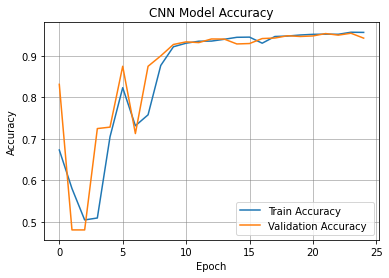

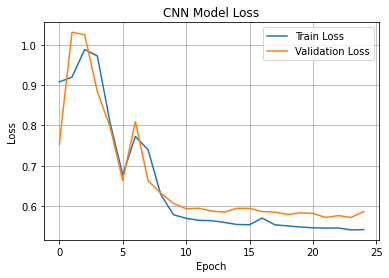

In [282]:
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy '], loc='down right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()


plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

### Model predication and evaluation

In [283]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

125/125 [==============================] - 1s 11ms/step - loss: 0.5865 - accuracy: 0.9425
Test Loss: 0.5865470767021179
Test Accuracy: 0.9424999952316284


In [284]:
CNN_scores = cnn_model.predict(x_test, verbose=1, batch_size=256)

16/16 [==============================] - 1s 38ms/step


In [285]:
CNN_scores

array([[1.4231233e-02],
       [9.9980742e-01],
       [3.3438948e-04],
       ...,
       [9.9997246e-01],
       [9.9998879e-01],
       [1.5839499e-04]], dtype=float32)

In [286]:
CNN_y_pred=np.where(CNN_scores>0.5,1,0)

In [287]:
CNN_y_pred

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [288]:
print(accuracy_score(y_test, CNN_y_pred))

0.9425


In [289]:
print(classification_report(y_test, CNN_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2077
           1       0.93      0.96      0.94      1923

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



### confusion_matrix

In [103]:
CNN_CM=confusion_matrix(y_test, CNN_y_pred)
print(CNN_CM)

[[ 881 1196]
 [   1 1922]]


In [104]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[ 881 1196]
 [   1 1922]]


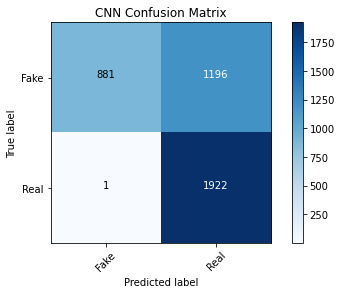

In [105]:
categories = ['Fake','Real']
CNN_cnf_matrix = confusion_matrix(y_test, CNN_y_pred)
plot_confusion_matrix(cm=CNN_cnf_matrix, classes=categories, title='CNN Confusion Matrix')
plt.show()

## BiLSTM_RNN(Bahad et al., 2019)

In [107]:
BiLSTM_RNN_model= tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),

    tf.keras.layers.SpatialDropout1D(0.20),
    tf.keras.layers.LSTM((128), return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM((256)),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [108]:
BiLSTM_RNN_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [109]:
print(BiLSTM_RNN_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 600, 200)          9712800   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 600, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 600, 128)          168448    
                                                                 
 dropout_10 (Dropout)        (None, 600, 128)          0         
                                                                 
 lstm_8 (LSTM)               (None, 256)               394240    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                      

### Model training 

In [110]:
number_of_epochs = 25
batch_size = 256

BiLSTM_RNN_history = BiLSTM_RNN_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/25
63/63 [==============================] - 18s 240ms/step - loss: 1.0071 - accuracy: 0.5087 - val_loss: 0.9888 - val_accuracy: 0.5645
Epoch 2/25
63/63 [==============================] - 15s 233ms/step - loss: 0.9896 - accuracy: 0.5244 - val_loss: 0.9427 - val_accuracy: 0.5688
Epoch 3/25
63/63 [==============================] - 15s 231ms/step - loss: 0.5540 - accuracy: 0.7473 - val_loss: 0.1968 - val_accuracy: 0.9155
Epoch 4/25
63/63 [==============================] - 14s 230ms/step - loss: 0.7426 - accuracy: 0.6376 - val_loss: 0.8577 - val_accuracy: 0.5735
Epoch 5/25
63/63 [==============================] - 14s 227ms/step - loss: 0.7839 - accuracy: 0.6151 - val_loss: 0.2937 - val_accuracy: 0.8825
Epoch 6/25
63/63 [==============================] - 14s 226ms/step - loss: 0.2942 - accuracy: 0.8744 - val_loss: 0.3848 - val_accuracy: 0.8282
Epoch 7/25
63/63 [==============================] - 14s 223ms/step - loss: 0.3881 - accuracy: 0.8309 - val_loss: 0.3733 - val_accuracy: 0.8310

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'down right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


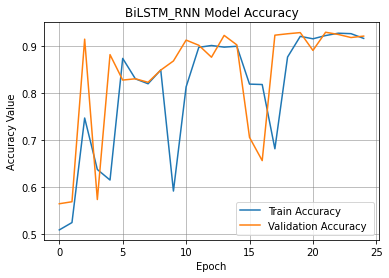

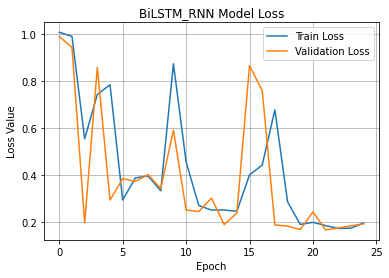

In [112]:
plt.plot(BiLSTM_RNN_history.history['accuracy'])
plt.plot(BiLSTM_RNN_history.history['val_accuracy'])
plt.title('BiLSTM_RNN Model Accuracy')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy '], loc='down right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()


plt.plot(BiLSTM_RNN_history.history['loss'])
plt.plot(BiLSTM_RNN_history.history['val_loss'])
plt.title('BiLSTM_RNN Model Loss')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

### Model predication and evaluation

In [113]:
test_loss, test_acc = BiLSTM_RNN_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

125/125 [==============================] - 3s 26ms/step - loss: 0.1924 - accuracy: 0.9220
Test Loss: 0.1923624724149704
Test Accuracy: 0.921999990940094


In [114]:
BiLSTM_RNN_scores = BiLSTM_RNN_model.predict(x_test, verbose=1, batch_size=256)

16/16 [==============================] - 2s 78ms/step


In [115]:
BiLSTM_RNN_scores

array([[-1.4723136],
       [ 0.9591374],
       [-1.4723152],
       ...,
       [ 0.9591374],
       [ 0.9591374],
       [-1.4723132]], dtype=float32)

In [116]:
BiLSTM_RNN_y_pred=np.where(BiLSTM_RNN_scores>0.5,1,0)

In [117]:
BiLSTM_RNN_y_pred

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [118]:
print(accuracy_score(y_test, BiLSTM_RNN_y_pred))

0.922


In [119]:
print(classification_report(y_test, BiLSTM_RNN_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2077
           1       0.89      0.96      0.92      1923

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



### confusion_matrix

In [120]:
BiLSTM_RNN_CM=confusion_matrix(y_test,BiLSTM_RNN_y_pred)
print(BiLSTM_RNN_CM)

[[1846  231]
 [  81 1842]]


In [121]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[1846  231]
 [  81 1842]]


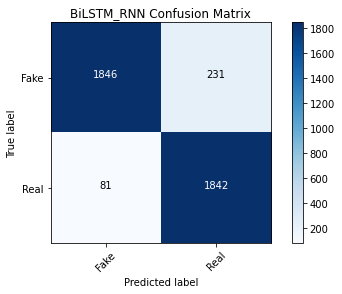

In [122]:
categories = ['Fake','Real']
BiLSTM_RNN_cnf_matrix = confusion_matrix(y_test, BiLSTM_RNN_y_pred)
plot_confusion_matrix(cm=BiLSTM_RNN_cnf_matrix, classes=categories, title='BiLSTM_RNN Confusion Matrix')
plt.show()

### Model ROC Curve

In [123]:
from sklearn import metrics

In [124]:
BiLSTM_RNN_fpr, BiLSTM_RNN_tpr, _ = metrics.roc_curve(y_test,BiLSTM_RNN_y_pred)
BiLSTM_RNN_roc_auc = metrics.auc(BiLSTM_RNN_fpr, BiLSTM_RNN_tpr)

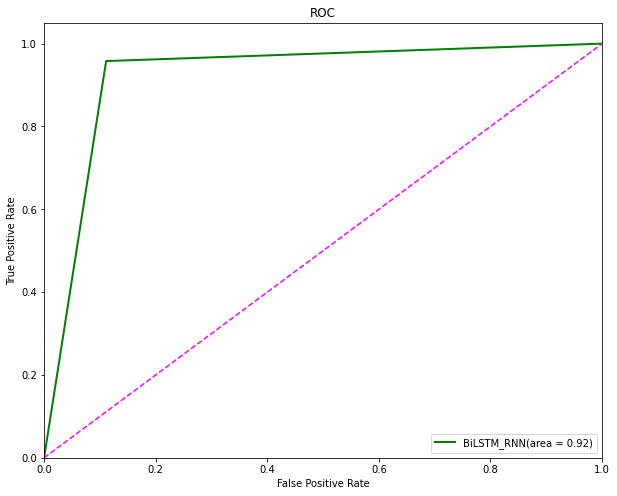

In [125]:
plt.figure(figsize=(10,8))
lw = 2
plt.plot(BiLSTM_RNN_fpr, BiLSTM_RNN_tpr, color='green', lw=lw, label='BiLSTM_RNN(area = %0.2f)' % BiLSTM_RNN_roc_auc)
plt.plot([0, 1], [0, 1], color='magenta', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## LSTM-RNN (T. Ahmed et al 2022)

In [126]:
model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),

    tf.keras.layers.SpatialDropout1D(0.20),
    tf.keras.layers.LSTM((128), return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM((128)),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])
model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 600, 200)          9712800   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 600, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_9 (LSTM)               (None, 600, 128)          168448    
                                                                 
 dropout_12 (Dropout)        (None, 600, 128)          0         
                                                                 
 lstm_10 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                      

### Model Training 

In [127]:
number_of_epochs = 25
batch_size = 256

LSTM_RNN_history = model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/25
63/63 [==============================] - 13s 156ms/step - loss: 1.0113 - accuracy: 0.5028 - val_loss: 1.0043 - val_accuracy: 0.5380
Epoch 2/25
63/63 [==============================] - 9s 147ms/step - loss: 0.9694 - accuracy: 0.5442 - val_loss: 0.8959 - val_accuracy: 0.5822
Epoch 3/25
63/63 [==============================] - 9s 145ms/step - loss: 0.5145 - accuracy: 0.7746 - val_loss: 0.2711 - val_accuracy: 0.8895
Epoch 4/25
63/63 [==============================] - 9s 144ms/step - loss: 0.3064 - accuracy: 0.8746 - val_loss: 0.2801 - val_accuracy: 0.8745
Epoch 5/25
63/63 [==============================] - 9s 144ms/step - loss: 0.2749 - accuracy: 0.8864 - val_loss: 0.2767 - val_accuracy: 0.8737
Epoch 6/25
63/63 [==============================] - 9s 143ms/step - loss: 0.2768 - accuracy: 0.8834 - val_loss: 0.1966 - val_accuracy: 0.9137
Epoch 7/25
63/63 [==============================] - 9s 143ms/step - loss: 0.2942 - accuracy: 0.8746 - val_loss: 0.3652 - val_accuracy: 0.8405
Epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'down right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


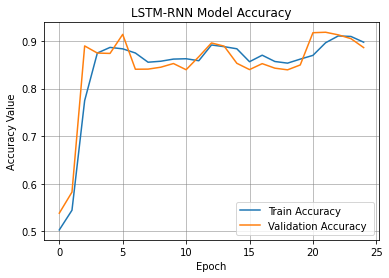

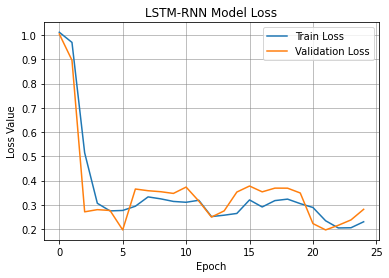

In [129]:
plt.plot(LSTM_RNN_history.history['accuracy'])
plt.plot(LSTM_RNN_history.history['val_accuracy'])
plt.title('LSTM-RNN Model Accuracy')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy '], loc='down right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()


plt.plot(LSTM_RNN_history.history['loss'])
plt.plot(LSTM_RNN_history.history['val_loss'])
plt.title('LSTM-RNN Model Loss')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

### Model predication and evaluation

In [130]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

125/125 [==============================] - 3s 26ms/step - loss: 0.2815 - accuracy: 0.8860
Test Loss: 0.28151795268058777
Test Accuracy: 0.8859999775886536


In [131]:
model_scores = model.predict(x_test, verbose=1, batch_size=256)

16/16 [==============================] - 1s 52ms/step


In [132]:
model_y_pred=np.where(model_scores>0.5,1,0)

In [133]:
model_y_pred

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [134]:
print(accuracy_score(y_test, model_y_pred))

0.886


In [135]:
print(classification_report(y_test, model_y_pred))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      2077
           1       0.82      0.97      0.89      1923

    accuracy                           0.89      4000
   macro avg       0.90      0.89      0.89      4000
weighted avg       0.90      0.89      0.89      4000



### confusion_matrix

In [136]:
model_CM=confusion_matrix(y_test, model_y_pred)
print(model_CM)

[[1681  396]
 [  60 1863]]


In [137]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[1681  396]
 [  60 1863]]


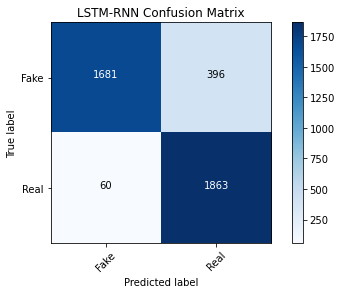

In [138]:
categories = ['Fake','Real']
LSTM_RNN_cnf_matrix = confusion_matrix(y_test, model_y_pred)
plot_confusion_matrix(cm=LSTM_RNN_cnf_matrix, classes=categories, title='LSTM-RNN Confusion Matrix')
plt.show()

### Model ROC Curve

In [139]:
from sklearn import metrics

In [140]:
LSTM_RNN_fpr, LSTM_RNN_tpr, _ = metrics.roc_curve(y_test,model_y_pred)
LSTM_RNN_roc_auc = metrics.auc(LSTM_RNN_fpr, LSTM_RNN_tpr)

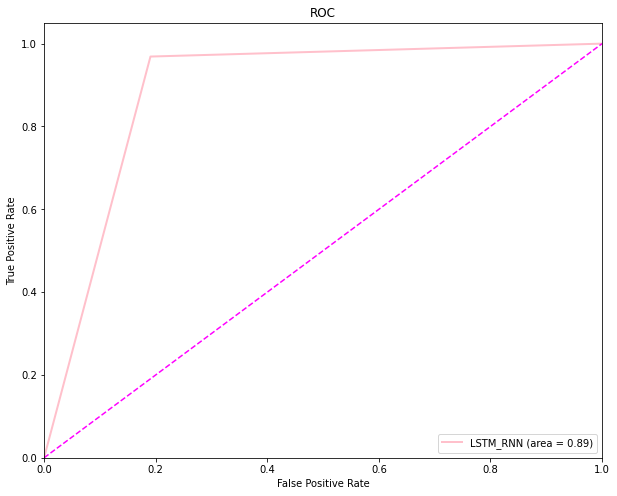

In [141]:
plt.figure(figsize=(10,8))
lw = 2
plt.plot(LSTM_RNN_fpr, LSTM_RNN_tpr, color='pink', lw=lw, label='LSTM_RNN (area = %0.2f)' % LSTM_RNN_roc_auc)
plt.plot([0, 1], [0, 1], color='magenta', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### BiLSTM_CNN (Nasir, Khan et al, 2021)

In [205]:

BiLSTM_CNN_model = model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dimension,
                              weights=[embedding_matrix],
                              input_length=max_word_length,
                              trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),


    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(256, 4, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [206]:
BiLSTM_CNN_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [207]:
print(BiLSTM_CNN_model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 600, 200)          9712800   
                                                                 
 dropout_26 (Dropout)        (None, 600, 200)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, 596, 32)           32032     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 149, 32)          0         
 g1D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 149, 32)           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 145, 64)           10304     
                                                     

### Model Training 

In [208]:
number_of_epochs = 25
batch_size = 256

BiLSTM_CNN_history = BiLSTM_CNN_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/25
63/63 [==============================] - 6s 44ms/step - loss: 0.9429 - accuracy: 0.5493 - val_loss: 0.8944 - val_accuracy: 0.7318
Epoch 2/25
63/63 [==============================] - 2s 29ms/step - loss: 0.6797 - accuracy: 0.8827 - val_loss: 0.6221 - val_accuracy: 0.9220
Epoch 3/25
63/63 [==============================] - 2s 30ms/step - loss: 0.5804 - accuracy: 0.9262 - val_loss: 0.5905 - val_accuracy: 0.9385
Epoch 4/25
63/63 [==============================] - 2s 29ms/step - loss: 0.5665 - accuracy: 0.9350 - val_loss: 0.5815 - val_accuracy: 0.9430
Epoch 5/25
63/63 [==============================] - 2s 30ms/step - loss: 0.5598 - accuracy: 0.9388 - val_loss: 0.5754 - val_accuracy: 0.9477
Epoch 6/25
63/63 [==============================] - 2s 29ms/step - loss: 0.5518 - accuracy: 0.9476 - val_loss: 0.5719 - val_accuracy: 0.9495
Epoch 7/25
63/63 [==============================] - 2s 30ms/step - loss: 0.5499 - accuracy: 0.9476 - val_loss: 0.5681 - val_accuracy: 0.9538
Epoch 8/25
63

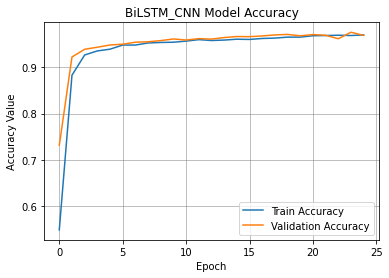

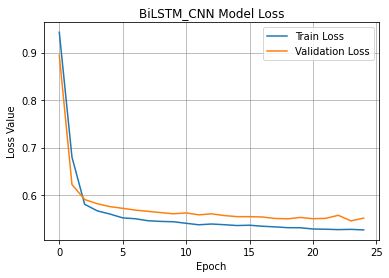

In [209]:
plt.plot(BiLSTM_CNN_history.history['accuracy'])
plt.plot(BiLSTM_CNN_history.history['val_accuracy'])
plt.title('BiLSTM_CNN Model Accuracy')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

plt.plot(BiLSTM_CNN_history.history['loss'])
plt.plot(BiLSTM_CNN_history.history['val_loss'])
plt.title('BiLSTM_CNN Model Loss')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

### Model predication and evaluation

In [210]:
test_loss, test_acc = BiLSTM_CNN_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

125/125 [==============================] - 1s 5ms/step - loss: 0.5512 - accuracy: 0.9685
Test Loss: 0.551241397857666
Test Accuracy: 0.968500018119812


In [211]:
BiLSTM_CNN_scores = BiLSTM_CNN_model.predict(x_test, verbose=1, batch_size=256)

16/16 [==============================] - 1s 12ms/step


In [212]:
BiLSTM_CNN_scores

array([[9.7649732e-05],
       [9.9999654e-01],
       [4.8609490e-06],
       ...,
       [9.9999070e-01],
       [9.9999344e-01],
       [1.8400464e-05]], dtype=float32)

In [213]:
BiLSTM_CNN_y_pred=np.where(BiLSTM_CNN_scores>0.5,1,0)

In [214]:
BiLSTM_CNN_y_pred

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [215]:
print(accuracy_score(y_test, BiLSTM_CNN_y_pred))

0.9685


In [216]:
print(classification_report(y_test, BiLSTM_CNN_y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2077
           1       0.95      0.99      0.97      1923

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



### confusion_matrix

In [217]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[1972  105]
 [  21 1902]]


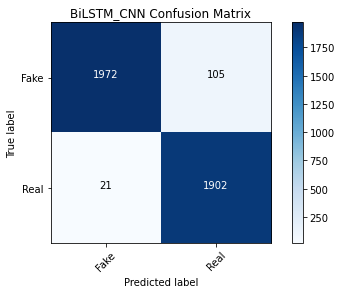

In [218]:
categories = ['Fake','Real']
BiLSTM_CNN_cnf_matrix = confusion_matrix(y_test, BiLSTM_CNN_y_pred)
plot_confusion_matrix(cm=BiLSTM_CNN_cnf_matrix, classes=categories, title='BiLSTM_CNN Confusion Matrix')
plt.show()

### Model ROC Curve

In [219]:
BiLSTM_CNN_fpr, BiLSTM_CNN_tpr, _ = metrics.roc_curve(y_test,BiLSTM_CNN_y_pred)
BiLSTM_CNN_roc_auc = metrics.auc(BiLSTM_CNN_fpr, BiLSTM_CNN_tpr)

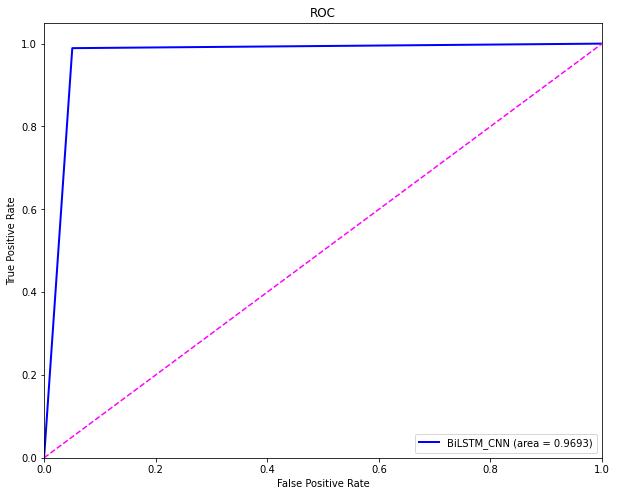

In [221]:
plt.figure(figsize=(10,8))
lw = 2
plt.plot(BiLSTM_CNN_fpr, BiLSTM_CNN_tpr, color='blue', lw=lw, label='BiLSTM_CNN (area = %0.4f)' % BiLSTM_CNN_roc_auc)
plt.plot([0, 1], [0, 1], color='magenta', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## BLD-GRU (Hansrajh et al., 2021)

In [166]:
BLD_GRU_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.10),
    tf.keras.layers.GRU((128), return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.GRU((128)),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [167]:
BLD_GRU_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [168]:
print(BLD_GRU_model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 600, 200)          9712800   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 600, 200)         0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 600, 128)          126720    
                                                                 
 dropout_18 (Dropout)        (None, 600, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                     

### Model Training 

In [169]:
number_of_epochs = 25
batch_size = 256

BLD_GRU_history = BLD_GRU_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/25
63/63 [==============================] - 12s 135ms/step - loss: 1.0151 - accuracy: 0.4971 - val_loss: 1.0069 - val_accuracy: 0.5328
Epoch 2/25
63/63 [==============================] - 8s 123ms/step - loss: 1.0044 - accuracy: 0.5084 - val_loss: 1.0044 - val_accuracy: 0.5347
Epoch 3/25
63/63 [==============================] - 8s 123ms/step - loss: 1.0022 - accuracy: 0.5096 - val_loss: 1.0012 - val_accuracy: 0.5345
Epoch 4/25
63/63 [==============================] - 8s 124ms/step - loss: 1.0002 - accuracy: 0.5102 - val_loss: 0.9995 - val_accuracy: 0.5347
Epoch 5/25
63/63 [==============================] - 8s 126ms/step - loss: 0.9984 - accuracy: 0.5113 - val_loss: 0.9972 - val_accuracy: 0.5353
Epoch 6/25
63/63 [==============================] - 8s 127ms/step - loss: 0.9965 - accuracy: 0.5115 - val_loss: 0.9931 - val_accuracy: 0.5357
Epoch 7/25
63/63 [==============================] - 8s 130ms/step - loss: 0.9982 - accuracy: 0.5202 - val_loss: 1.0196 - val_accuracy: 0.4975
Epoch

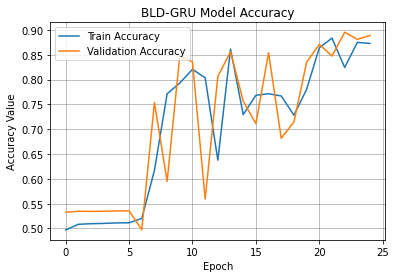

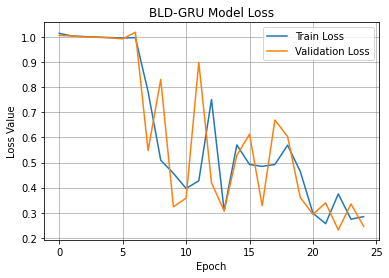

In [170]:
plt.plot(BLD_GRU_history.history['accuracy'])
plt.plot(BLD_GRU_history.history['val_accuracy'])
plt.title('BLD-GRU Model Accuracy')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

plt.plot(BLD_GRU_history.history['loss'])
plt.plot(BLD_GRU_history.history['val_loss'])
plt.title('BLD-GRU Model Loss')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

### Model predication and evaluation

In [171]:
test_loss, test_acc = BLD_GRU_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

125/125 [==============================] - 3s 21ms/step - loss: 0.2459 - accuracy: 0.8890
Test Loss: 0.24590489268302917
Test Accuracy: 0.8889999985694885


In [172]:
BLD_GRU_scores = BLD_GRU_model.predict(x_test, verbose=1, batch_size=256)

16/16 [==============================] - 1s 48ms/step


In [173]:
BLD_GRU_scores

array([[-1.2783322 ],
       [ 0.97442347],
       [-1.2783324 ],
       ...,
       [ 0.97440505],
       [ 0.9743836 ],
       [-1.2783324 ]], dtype=float32)

In [174]:
BLD_GRU_y_pred=np.where(BLD_GRU_scores>0.4,1,0)

In [175]:
BLD_GRU_y_pred

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [176]:
print(accuracy_score(y_test, BLD_GRU_y_pred))

0.889


In [177]:
print(classification_report(y_test, BLD_GRU_y_pred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      2077
           1       0.85      0.94      0.89      1923

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



### confusion_matrix

In [178]:
BLD_GRU_CM=confusion_matrix(y_test, BLD_GRU_y_pred)
print(BLD_GRU_CM)

[[1746  331]
 [ 113 1810]]


In [179]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[1746  331]
 [ 113 1810]]


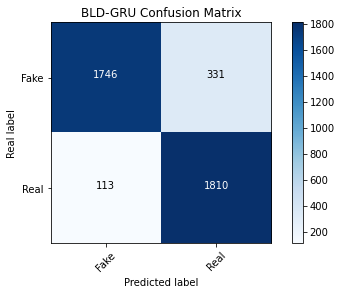

In [180]:
categories = ['Fake','Real']
BLD_GRU_cnf_matrix = confusion_matrix(y_test, BLD_GRU_y_pred)
plot_confusion_matrix(cm=BLD_GRU_cnf_matrix, classes=categories, title='BLD-GRU Confusion Matrix')
plt.show()

### ROC Curve

In [181]:
from sklearn import metrics
BLD_GRU_fpr, BLD_GRU_tpr, _ = metrics.roc_curve(y_test,BLD_GRU_y_pred)
BLD_GRU_roc_auc = metrics.auc(BLD_GRU_fpr, BLD_GRU_tpr)

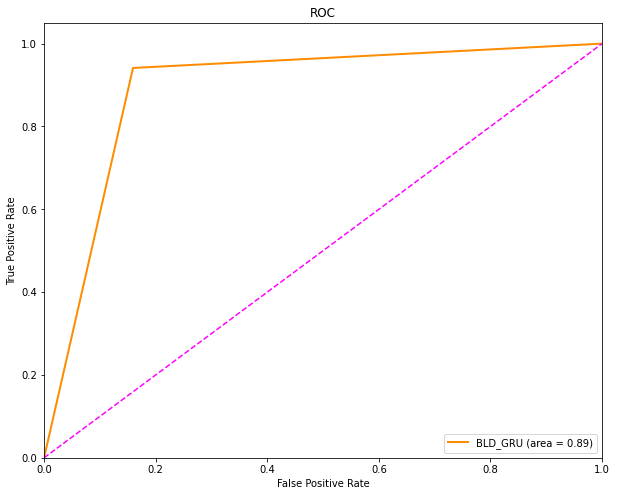

In [182]:
plt.figure(figsize=(10,8))
lw = 2
plt.plot(BLD_GRU_fpr, BLD_GRU_tpr, color='darkorange', lw=lw, label='BLD_GRU (area = %0.2f)' % BLD_GRU_roc_auc)
plt.plot([0, 1], [0, 1], color='magenta', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Proposed Hybrid Framework 

In [238]:
from keras.callbacks import EarlyStopping
overfitCallback = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1, mode='auto')

DCNN_SVM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv1D(32, 5, activation='relu'),
  tf.keras.layers.MaxPooling1D(pool_size=4),

  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv1D(64, 5, activation='relu'),
  tf.keras.layers.MaxPooling1D(pool_size=4),

  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv1D(128, 5, activation='relu'),
  tf.keras.layers.MaxPooling1D(pool_size=4),

  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv1D(256, 5, activation='relu'),
  tf.keras.layers.MaxPooling1D(pool_size=4),

  tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(240)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

DCNN_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#DCNN_SVM_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#DCNN_SVM.pop() # this will remove the last layer
#DCNN_SVM.summary() # check the network

feature_mapping = DCNN_SVM_model(x_test)
from sklearn import svm
clf = svm.SVC()
clf.fit(feature_mapings, y)

print(DCNN_SVM_model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 600, 200)          9712800   
                                                                 
 dropout_44 (Dropout)        (None, 600, 200)          0         
                                                                 
 conv1d_28 (Conv1D)          (None, 596, 32)           32032     
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 149, 32)          0         
 g1D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 149, 32)           0         
                                                                 
 conv1d_29 (Conv1D)          (None, 145, 64)           10304     
                                                     

### Training of Proposed framework

In [239]:
number_of_epochs = 25
batch_size = 256

DCNN_SVM_model_history = DCNN_SVM_model.fit(x_train, y_train, 
                                    epochs = number_of_epochs,
                                    batch_size = batch_size,
                   validation_data=(x_test, y_test), 
                                    verbose=1)

Epoch 1/25
63/63 [==============================] - 6s 46ms/step - loss: 0.9492 - accuracy: 0.5317 - val_loss: 0.9181 - val_accuracy: 0.6802
Epoch 2/25
63/63 [==============================] - 2s 30ms/step - loss: 0.8376 - accuracy: 0.6883 - val_loss: 0.8168 - val_accuracy: 0.7097
Epoch 3/25
63/63 [==============================] - 2s 30ms/step - loss: 0.7998 - accuracy: 0.7008 - val_loss: 0.7814 - val_accuracy: 0.7423
Epoch 4/25
63/63 [==============================] - 2s 33ms/step - loss: 0.6950 - accuracy: 0.8106 - val_loss: 0.6140 - val_accuracy: 0.9130
Epoch 5/25
63/63 [==============================] - 2s 31ms/step - loss: 0.5826 - accuracy: 0.9176 - val_loss: 0.5991 - val_accuracy: 0.9237
Epoch 6/25
63/63 [==============================] - 2s 31ms/step - loss: 0.5706 - accuracy: 0.9274 - val_loss: 0.5885 - val_accuracy: 0.9337
Epoch 7/25
63/63 [==============================] - 2s 30ms/step - loss: 0.5648 - accuracy: 0.9325 - val_loss: 0.5829 - val_accuracy: 0.9388
Epoch 8/25
63

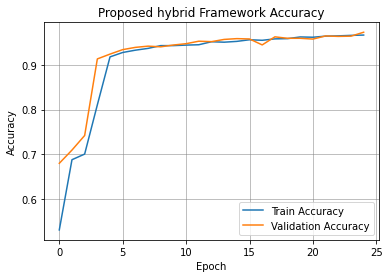

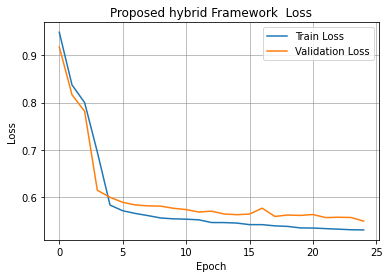

In [240]:
plt.plot(DCNN_SVM_model_history.history['accuracy'])
plt.plot(DCNN_SVM_model_history.history['val_accuracy'])
plt.title('Proposed hybrid Framework Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

plt.plot(DCNN_SVM_model_history.history['loss'])
plt.plot(DCNN_SVM_model_history.history['val_loss'])
plt.title('Proposed hybrid Framework  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

### Model predication and evaluation

In [241]:
test_loss, test_acc = DCNN_SVM_model.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

125/125 [==============================] - 1s 5ms/step - loss: 0.5486 - accuracy: 0.9725
Test Loss: 0.5485959649085999
Test Accuracy: 0.9725000262260437


In [242]:
DCNN_SVM_scores = DCNN_SVM_model.predict(x_test, verbose=1, batch_size=256)

16/16 [==============================] - 1s 12ms/step


In [243]:
DCNN_SVM_scores

array([[2.4988717e-06],
       [9.9999344e-01],
       [1.3447608e-07],
       ...,
       [9.9996841e-01],
       [9.9999869e-01],
       [8.5904057e-06]], dtype=float32)

In [244]:
DCNN_SVM_y_pred=np.where(DCNN_SVM_scores>0.5,1,0)


In [245]:
DCNN_SVM_y_pred


array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [246]:
print(accuracy_score(y_test, DCNN_SVM_y_pred))

0.9725


In [247]:
print(classification_report(y_test, DCNN_SVM_y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2077
           1       0.96      0.98      0.97      1923

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



### Confusion Matrix

In [249]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalisation
[[2006   71]
 [  39 1884]]


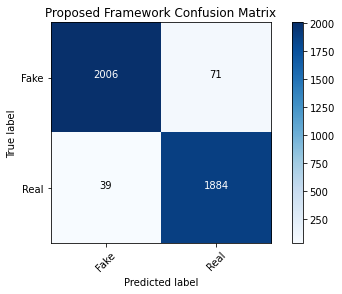

In [250]:
categories = ['Fake','Real']
DCNN_SVM_cnf_matrix = confusion_matrix(y_test, DCNN_SVM_y_pred)
plot_confusion_matrix(cm=DCNN_SVM_cnf_matrix, classes=categories, title='Proposed Framework Confusion Matrix')
plt.show()

###  ROC Curve

In [251]:
DCNN_SVM_fpr, DCNN_SVM_tpr, _ = metrics.roc_curve(y_test,DCNN_SVM_y_pred)
DCNN_SVM_roc_auc = metrics.auc(DCNN_SVM_fpr, DCNN_SVM_tpr)

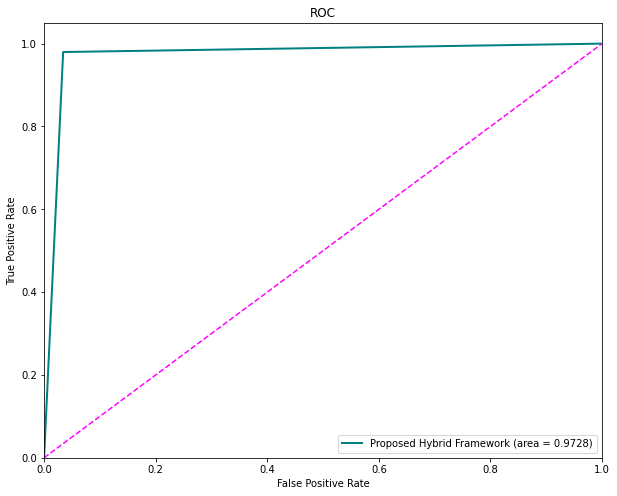

In [252]:
plt.figure(figsize=(10,8))
lw = 2
plt.plot(DCNN_SVM_fpr, DCNN_SVM_tpr, color='teal', lw=lw, label='Proposed Hybrid Framework (area = %0.4f)' % DCNN_SVM_roc_auc)
plt.plot([0, 1], [0, 1], color='magenta', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Performance Evaluation ROC Curves of all Models 

In [253]:
#LSTM_fpr, LSTM_tpr, _ = metrics.roc_curve(y_test,LSTM_y_pred)
#LSTM_roc_auc = metrics.auc(LSTM_fpr, LSTM_tpr)

#BiLSTM_RNN
BiLSTM_RNN_fpr, BiLSTM_RNN_tpr, _ = metrics.roc_curve(y_test,BiLSTM_RNN_y_pred)
BiLSTM_RNN_roc_auc = metrics.auc(BiLSTM_RNN_fpr, BiLSTM_RNN_tpr)

#LSTM_RNN
LSTM_RNN_fpr, LSTM_RNN_tpr, _ = metrics.roc_curve(y_test,model_y_pred)
LSTM_RNN_roc_auc = metrics.auc(LSTM_RNN_fpr, LSTM_RNN_tpr)

#BiLSTM_CNN
BiLSTM_CNN_fpr, BiLSTM_CNN_tpr, _ = metrics.roc_curve(y_test,BiLSTM_CNN_y_pred)
BiLSTM_CNN_roc_auc = metrics.auc(BiLSTM_CNN_fpr, BiLSTM_CNN_tpr)
#BLD_GRU
BLD_GRU_fpr, BLD_GRU_tpr, _ = metrics.roc_curve(y_test,BLD_GRU_y_pred)
BLD_GRU_roc_auc = metrics.auc(BLD_GRU_fpr, BLD_GRU_tpr)

#Proposed Hybrid Framework
DCNN_SVM_fpr, DCNN_SVM_tpr, _ = metrics.roc_curve(y_test,DCNN_SVM_y_pred)
DCNN_SVM_roc_auc = metrics.auc(DCNN_SVM_fpr, DCNN_SVM_tpr)


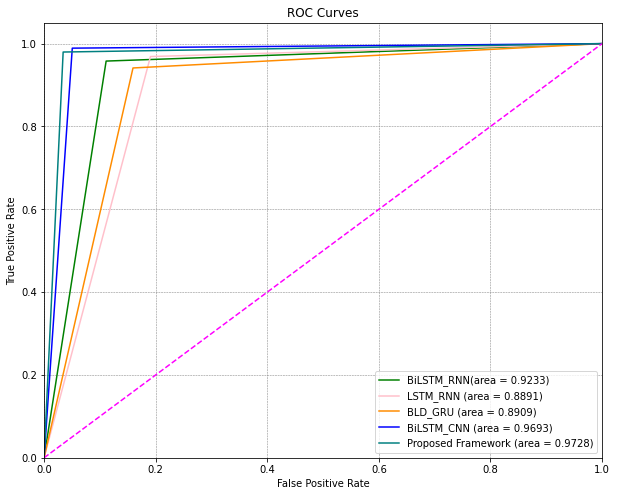

In [254]:
plt.figure(figsize=(10,8))
lw = 1.5
#plt.plot(LSTM_fpr, LSTM_tpr, color='orange', lw=lw, label='LSTM(area = %0.4f)' % LSTM_roc_auc)
plt.plot(BiLSTM_RNN_fpr, BiLSTM_RNN_tpr, color='green', lw=lw, label='BiLSTM_RNN(area = %0.4f)' % BiLSTM_RNN_roc_auc)
plt.plot(LSTM_RNN_fpr, LSTM_RNN_tpr, color='pink', lw=lw, label='LSTM_RNN (area = %0.4f)' % LSTM_RNN_roc_auc)
plt.plot(BLD_GRU_fpr, BLD_GRU_tpr, color='darkorange', lw=lw, label='BLD_GRU (area = %0.4f)' % BLD_GRU_roc_auc)
plt.plot(BiLSTM_CNN_fpr, BiLSTM_CNN_tpr, color='blue', lw=lw, label='BiLSTM_CNN (area = %0.4f)' % BiLSTM_CNN_roc_auc)
plt.plot(DCNN_SVM_fpr, DCNN_SVM_tpr, color='teal', lw=lw, label='Proposed Framework (area = %0.4f)' % DCNN_SVM_roc_auc)

plt.plot([0, 1], [0, 1], color='magenta', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()
